<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left"> REGRESIÓN LOGÍSTICA + REDUCCIÓN DE ATRIBUTOS + UNDERSAMPLING </h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [36]:
# Paquetes de manipulación de datos
import numpy as np 
import pandas as pd 
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

# Paquetes para aplicar el modelo: Regresión Logística
from sklearn import model_selection
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

## Importar DataSets
Importamos los datasets Train-Test y Evaluación para los que se ha aplicado la reducción de atributos y submuestreo para ajustar la distribución de la clase mayoritaria.

In [37]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

## TrainTest

In [38]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'train_test_under_dis.csv',Filename = '/tmp/train_test_under_dis.csv')

In [39]:
#Leemos el fichero y lo metemos en un dataframe.
trainTestDis = pd.read_csv('/tmp/train_test_under_dis.csv', dtype={'rank':'category'})

In [40]:
print (trainTestDis.shape)

(74130, 9)


In [41]:
trainTestDis.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,type,newbalanceOrig,isFraud
0,181.0,0.00,0.00,181.00,1,1,TRANSFER,0.0,1.0
1,181.0,-21182.00,0.00,181.00,1,1,CASH_OUT,0.0,1.0
2,2806.0,-26202.00,0.00,2806.00,1,1,CASH_OUT,0.0,1.0
3,20128.0,5877.85,12145.85,20128.00,1,1,CASH_OUT,0.0,1.0
4,0.0,9291517.62,9291619.62,416001.33,1,1,CASH_OUT,0.0,1.0


In [42]:
pd.value_counts(trainTestDis['isFraud'])

0.0    66717
1.0     7413
Name: isFraud, dtype: int64

In [43]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/train_test_under_dis.csv

## Evaluacion

In [44]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'eval_under_dis.csv',Filename = '/tmp/eval_under_dis.csv')

In [45]:
#Leemos el fichero y lo metemos en un dataframe.
evalDis = pd.read_csv('/tmp/eval_under_dis.csv', dtype={'rank':'category'})

In [46]:
print (evalDis.shape)

(80000, 9)


In [47]:
evalDis.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,type,newbalanceOrig,isFraud
0,10000000.00,10000000.00,11727027.89,10000000.00,18,17,CASH_OUT,0.0,1.0
1,545780.70,0.00,0.00,545780.70,22,18,TRANSFER,0.0,1.0
2,2079746.13,2079746.13,2079746.13,2079746.13,31,14,CASH_OUT,0.0,1.0
3,46081.45,0.00,0.00,46081.45,5,6,TRANSFER,0.0,1.0
4,50722.16,50722.15,72551.64,50722.16,17,14,CASH_OUT,0.0,1.0


In [48]:
pd.value_counts(evalDis['isFraud'])

0.0    79200
1.0      800
Name: isFraud, dtype: int64

In [49]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/eval_under_dis.csv

## Regresión Logística
En este caso, para el modelo de Regresión Logística no es necesario aplicar normalización en los datos puesto que este tipo de modelos no se ven afectados por los ordenes de magnitud de los atributos.

Aplicamos la tacnica Dummie a los dataframe trainTest y evaluacion

In [50]:
trainTestDisDummie = pd.get_dummies(trainTestDis, drop_first=True)

In [51]:
trainTestDisDummie.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,newbalanceOrig,isFraud,type_TRANSFER
0,181.0,0.00,0.00,181.00,1,1,0.0,1.0,1
1,181.0,-21182.00,0.00,181.00,1,1,0.0,1.0,0
2,2806.0,-26202.00,0.00,2806.00,1,1,0.0,1.0,0
3,20128.0,5877.85,12145.85,20128.00,1,1,0.0,1.0,0
4,0.0,9291517.62,9291619.62,416001.33,1,1,0.0,1.0,0


In [52]:
evalDisDummie = pd.get_dummies(evalDis, drop_first=True)

In [53]:
evalDisDummie.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,newbalanceOrig,isFraud,type_TRANSFER
0,10000000.00,10000000.00,11727027.89,10000000.00,18,17,0.0,1.0,0
1,545780.70,0.00,0.00,545780.70,22,18,0.0,1.0,1
2,2079746.13,2079746.13,2079746.13,2079746.13,31,14,0.0,1.0,0
3,46081.45,0.00,0.00,46081.45,5,6,0.0,1.0,1
4,50722.16,50722.15,72551.64,50722.16,17,14,0.0,1.0,0


### Entrenamiento y test del modelo

In [54]:
# Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
X = np.array(trainTestDisDummie.drop(['isFraud'],1))
y = np.array(trainTestDisDummie['isFraud'])

In [55]:
# Creamos los conjuntos de entrenamiento y test:
seed = 7
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=seed)

# Verificamos los tamaños de los df:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51891, 8), (22239, 8), (51891,), (22239,))

In [56]:
# Creamos el modelo de Regresión Logística Y creamos nuestro modelo y
# hacemos que se ajuste (fit) al conjunto de entradas X y salidas y de entrenamiento
regLogUnderRedDim = LogisticRegression()
regLogUnderRedDim.fit(X_train, y_train)

LogisticRegression()

In [57]:
name='Logistic Regression Undersampling PCA'
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(regLogUnderRedDim, X_train, y_train, cv=kfold, scoring='recall')
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Logistic Regression Undersampling PCA: 0.856625 (0.092106)


Una vez compilado el modelo, le hacemos clasificar el conjunto de entradas X_test utilizando el método `predict(X_test)`.

In [58]:
predictions = regLogUnderRedDim.predict(X_test)
print(recall_score(y_test, predictions))

0.9052537045352492


In [59]:
print(confusion_matrix(y_test, predictions))

[[19422   590]
 [  211  2016]]


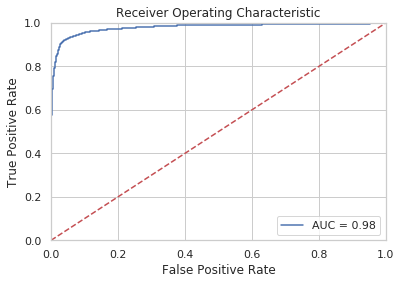

In [60]:
# Área bajo la curva ROC:  
    # Para calcular el área bajo la curva ROC (AUC) es necesario obtener
    # la probabilidad de salida del clasificador con `predict_proba`
prediccion_prob = regLogUnderRedDim.predict_proba(X_test)
#la primera columna corresponde a la etiqueta 'N'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta N)
roc_auc_score((y_test==0), prediccion_prob[:,0])

probs = regLogUnderRedDim.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Clasificación de nuevos valores

In [61]:
# Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
evalX = np.array(evalDisDummie.drop(['isFraud'],1))
evaly = np.array(evalDisDummie['isFraud'])

In [62]:
# Aplicamos el modelo
regLogUnderRedDim.score(evalX, evaly)

0.9715875

In [63]:
# Calculamos la predicción
predEval = regLogUnderRedDim.predict(evalX)

In [64]:
# Matriz de confusión
cm=confusion_matrix(evaly, predEval)
pd.DataFrame(cm, index=('0_true','1_true'), columns=('0_pred','1_pred'))

,0_pred,1_pred
0_true,77007,2193
1_true,80,720


In [65]:
pru = np.where(predEval > 0.4,1,0)
print(classification_report(evaly, pru))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     79200
         1.0       0.25      0.90      0.39       800

    accuracy                           0.97     80000
   macro avg       0.62      0.94      0.69     80000
weighted avg       0.99      0.97      0.98     80000



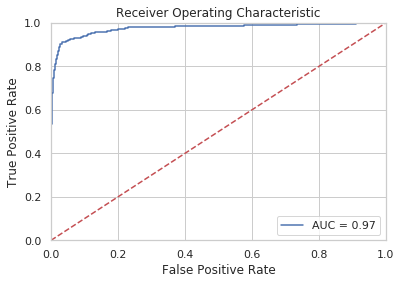

In [66]:
# Curva ROC
probs_eval = regLogUnderRedDim.predict_proba(evalX)
preds_eval = probs_eval[:,1]
fpr_eval, tpr_eval, threshold_eval = metrics.roc_curve(evaly, preds_eval)
roc_auc_eval = metrics.auc(fpr_eval, tpr_eval)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_eval, tpr_eval, 'b', label = 'AUC = %0.2f' % roc_auc_eval)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Guardamos la predicción
Guardamos la predicción realizada en el dataframe de Evaluación:

In [ ]:
predRL = pd.DataFrame(predEval, columns = ["RLUnderRedDim_pred"])
modelResult = pd.concat([evalDis, predRL["RLUnderRedDim_pred"]],axis = 1)
modelResult.head()

In [ ]:
pd.crosstab(index=modelResult['isFraud'],columns=modelResult['RLUnderRedDim_pred'], margins=True)